# Evaluation of Token Classification with OpenAI GPT Models


## Import Python packages

In [51]:
from os import listdir
from os.path import isfile, join
import json

import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset
from utils import filter_ner_io

import warnings
warnings.filterwarnings('ignore')

## Import dataset

In this experiment, we use the GeoEDdA dataset which contains semantic annotations (at the token and span levels) for named entities (i.e., Spatial, Person, and Misc), nominal entities, spatial relations, and geographic coordinates. Nested named entities also present in this dataset were not considered in this experiment.

The dataset is available in the HuggingFace Hub: https://huggingface.co/datasets/GEODE/GeoEDdA

* Load the GeoEDdA dataset from the HuggingFace Hub:

In [2]:
dataset = load_dataset("GEODE/GeoEDdA")
test_set = pd.DataFrame(dataset['test'])
test_set.head()

,text,meta,tokens,spans
0,"COMPIEGNE, (Géog. mod.) ville de France, dans ...","{'volume': 3, 'head': 'COMPIEGNE', 'author': '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '..."
1,"HILPERHAUSEN, (Géog.) ville d'Allemagne en Fra...","{'volume': 8, 'head': 'HILPERHAUSEN', 'author'...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1..."
2,"Patane ou Patany, (Géog. mod.) royaume des Ind...","{'volume': 12, 'head': 'Patane ou Patany', 'au...","[{'text': 'Patane', 'start': 0, 'end': 6, 'id'...","[{'text': 'Patane ou Patany', 'start': 0, 'end..."
3,"* ABYDE ou ABYDOS, sub. Ville maritime de Phry...","{'volume': 1, 'head': 'ABYDE ou ABYDOS', 'auth...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ABYDE ou ABYDOS', 'start': 2, 'end'..."
4,"DUSSELDORP, (Géog. mod.) ville du cercle de We...","{'volume': 5, 'head': 'DUSSELDORP', 'author': ...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,..."


* Add a new column with the list of tags (one tag per token):

In [3]:
tagset = ['Domain-mark','Head','NC-Person','NC-Spatial','NP-Misc','NP-Person','NP-Spatial','Relation','Latlong', 'ENE-Spatial', 'ENE-Person', 'ENE-Misc']

test_set['tags'] = test_set.apply(lambda x: filter_ner_io(x, tagset), axis=1)
test_set.head()

,text,meta,tokens,spans,tags
0,"COMPIEGNE, (Géog. mod.) ville de France, dans ...","{'volume': 3, 'head': 'COMPIEGNE', 'author': '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[{'text': 'COMPIEGNE', 'start': 0, 'end': 9, '...","[[Head], [O], [O], [Domain-mark], [Domain-mark..."
1,"HILPERHAUSEN, (Géog.) ville d'Allemagne en Fra...","{'volume': 8, 'head': 'HILPERHAUSEN', 'author'...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[{'text': 'HILPERHAUSEN', 'start': 0, 'end': 1...","[[Head], [O], [O], [Domain-mark], [Domain-mark..."
2,"Patane ou Patany, (Géog. mod.) royaume des Ind...","{'volume': 12, 'head': 'Patane ou Patany', 'au...","[{'text': 'Patane', 'start': 0, 'end': 6, 'id'...","[{'text': 'Patane ou Patany', 'start': 0, 'end...","[[Head], [Head], [Head], [O], [O], [Domain-mar..."
3,"* ABYDE ou ABYDOS, sub. Ville maritime de Phry...","{'volume': 1, 'head': 'ABYDE ou ABYDOS', 'auth...","[{'text': '*', 'start': 0, 'end': 1, 'id': 0, ...","[{'text': 'ABYDE ou ABYDOS', 'start': 2, 'end'...","[[O], [Head], [Head], [Head], [O], [O], [O], [..."
4,"DUSSELDORP, (Géog. mod.) ville du cercle de We...","{'volume': 5, 'head': 'DUSSELDORP', 'author': ...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[{'text': 'DUSSELDORP', 'start': 0, 'end': 10,...","[[Head], [O], [O], [Domain-mark], [Domain-mark..."


## Evaluation

Several iterations of the token classification task have been performed. The predictions from all the iterations can be loaded and evaluated.

In [45]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

def load_predictions(path):
    predictions = []
    for run in sorted(listdir(path)):
        files = sorted([f for f in listdir(join(path, run)) if isfile(join(path, run, f))])
        preds = []
        #print(files)
        for file in files:
            with open(join(path,run, file), encoding='utf-8') as f:
                preds.append(json.load(f))
        predictions.append(preds)

    return predictions

def formatting_ner(pred_sentence, true_sentence):
    formatted_pred_sentence = []
    i = 0
    j = 0

    if pred_sentence is not None:
        pred_entities = pred_sentence.get('entities', [])
        while i < len(pred_entities) and j < len(true_sentence['tokens']):
            pred_token = pred_entities[i]
            true_token = true_sentence['tokens'][j]

            if 'text' not in pred_token or pred_token['text'] != true_token['text']:
                formatted_pred_sentence.append(['O'])
                j += 1
                continue

            labels = pred_token.get('labels', pred_token.get('label', ['O']))
            if isinstance(labels, str):
                labels = [labels]
            formatted_pred_sentence.append(sorted(labels))
            i += 1
            j += 1

    # Handle remaining true tokens
    while j < len(true_sentence['tokens']):
        formatted_pred_sentence.append(['O'])
        j += 1

    return formatted_pred_sentence

#def formatting_ner(pred_sentence, true_sentence):
#    formatted_pred_sentence = []
#    i = 0
#    j = 0
#    if pred_sentence is not None:
#        while(i < len(pred_sentence['entities']) and j < len(true_sentence['tokens'])):
#            if('text' not in list(pred_sentence['entities'][i].keys())):
#                formatted_pred_sentence.append('O')
#                i += 1
#                j += 1
#            elif(pred_sentence['entities'][i]['text'] == true_sentence['tokens'][j]['text'] and 'labels' in list(pred_sentence['entities'][i].keys())):
#                formatted_pred_sentence.append(pred_sentence['entities'][i]['labels'])
#                i += 1
#                j += 1
#            else:
#                j += 1
#                formatted_pred_sentence.append('O')
#    while(j < len(true_sentence['tokens'])):
#        formatted_pred_sentence.append('O')
#        j += 1
#    return formatted_pred_sentence


def format_sentences(pred, true):
    formatted_pred_sentences = []
    for pred_sentence, true_sentence in zip(pred, true.iterrows()):
        formatted_pred_sentences.append(formatting_ner(pred_sentence,true_sentence[1]))
    return formatted_pred_sentences


def flatten_multilabel(true_tags_column):
    """
    Flattens a list of list of tags (sentence → tokens → tag(s)) into
    a flat list of sets per token, handling both list-of-labels and single-label formats.
    
    Case 1: tag is a list of labels → {'NP-Spatial', 'ENE-Spatial'}
    Case 2: tag is a single label → {'NP-Spatial'}
    """
    all_tags = []
    for sentence in true_tags_column:
        for token_tag in sentence:
            if isinstance(token_tag, list):
                # Case 1: Already a list of labels
                all_tags.append(set(token_tag))
            elif isinstance(token_tag, str):
                # Case 2: Single label
                all_tags.append(set([token_tag]))
            else:
                # Fallback
                all_tags.append(set())
    return all_tags

def format_predictions_multilabel(predictions, test_set):
    """
    Wraps predicted single-labels in sets, treating 'O' as empty set.
    """
    formatted_pred_sentences = format_sentences(predictions, test_set)
    return [
        set([tag]) if isinstance(tag, str) and tag != 'O' else set()
        for sentence in formatted_pred_sentences for tag in sentence
    ]



def evaluate_multilabel(predictions, test_set, tagset):
    """
    Évalue un modèle NER multilabel en comparant les prédictions avec les vraies étiquettes.
    Prend en charge les cas où les étiquettes sont soit des chaînes uniques soit des listes de labels.
    """

    all_true_labels = []
    all_pred_labels = []

    for pred_sentence, (_, true_sentence) in zip(predictions, test_set.iterrows()):
        pred_formatted = formatting_ner(pred_sentence, true_sentence)
        true_formatted = true_sentence['tags']

        # Assurer cohérence : transformer chaque tag en set
        pred_sets = [set(tags) if isinstance(tags, list) else set([tags]) for tags in pred_formatted]
        true_sets = [set(tags) if isinstance(tags, list) else set([tags]) for tags in true_formatted]

        all_pred_labels.extend(pred_sets)
        all_true_labels.extend(true_sets)

    # Binarisation multilabel
    mlb = MultiLabelBinarizer(classes=sorted(set(tagset)))
    y_true = mlb.fit_transform(all_true_labels)
    y_pred = mlb.transform(all_pred_labels)

    # Calcul des scores
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro', zero_division=0)

    # Organisation des scores
    metrics = {
        tag: {
            'precision': p,
            'recall': r,
            'f1-score': f,
            'support': s
        } for tag, p, r, f, s in zip(mlb.classes_, precision, recall, f1, support)
    }

    # Ajout des moyennes globales
    metrics['macro avg'] = {
        'precision': macro_precision,
        'recall': macro_recall,
        'f1-score': macro_f1,
        'support': sum(support)
    }
    metrics['micro avg'] = {
        'precision': micro_precision,
        'recall': micro_recall,
        'f1-score': micro_f1,
        'support': sum(support)
    }

    return metrics



def evaluate(predictions, test_set, tagset):
    classification_reports = []  
    for prediction in predictions:
        classification_reports.append(evaluate_multilabel(prediction, test_set, tagset))
    return classification_reports


def get_avg_scores(classification_reports, score='f1-score'):
    avg_scores = {}
    for report in classification_reports:
        for tag in report.keys():
            if tag not in avg_scores:
                avg_scores[tag] = []
            avg_scores[tag].append(report[tag][score])

    avg_scores = {tag: sum(scores)/len(scores) for tag, scores in avg_scores.items()}
    return avg_scores

def bar_plot(scores, tagset, score='f1-score'):
    fig, ax = plt.subplots(figsize=(12, 5))
    barWidth = 0.2

    # ➤ On retire 'O'
    filtered_tagset = [tag for tag in tagset if tag != 'O']

    # ➤ On ajoute 'micro' à la fin
    extended_tagset = filtered_tagset + ['micro']

    bars = []
    for model_scores in scores.values():
        bar = [model_scores.get(tag, 0) for tag in filtered_tagset]

        # ➤ Calcul de la moyenne micro
        micro_avg = np.average(bar)
        bar.append(micro_avg)

        bars.append(bar)

    rnge = np.arange(0, (len(bars[0]) * 1.2), 1.2)
    r = [rnge]
    for i in range(1, len(bars)):
        r.append([x + barWidth for x in r[i - 1]])

    colors = ['#0072B2', '#D55E00', '#CC79A7', '#E69F00', '#56B4E9']
    for i in range(len(bars)):
        ax.bar(r[i], bars[i], color=colors[i % len(colors)], width=barWidth, label=f'{list(scores.keys())[i]}')

    ax.set_xticks([x + barWidth for x in rnge])
    ax.set_xticklabels(extended_tagset, rotation=30)
    ax.tick_params(bottom=False, left=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    ax.set_xlabel('Token classes', labelpad=15, color='#333333')
    ax.set_ylabel(score, labelpad=15, color='#333333')
    plt.legend(loc=(1.04, 0.7))
    plt.show()

    return fig



def bar_plot(scores, tagset, score='f1-score'):
    fig, ax = plt.subplots(figsize=(12, 5))
    barWidth = 0.2
    bars = [[data[tag] for tag in tagset if tag != 'O'] for data in scores.values()]
    rnge = np.arange(0, (len(bars[0])*1.2), 1.2)
    r = [rnge]
    for i in range(1, len(bars)):
        r.append([x + barWidth for x in r[i-1]])
       

    
    colors = ['#0072B2', '#D55E00', '#CC79A7', '#E69F00', '#56B4E9'] # Colorblind-friendly palette
    for i in range(len(bars)):
        ax.bar(r[i], bars[i], color=colors[i], width=barWidth, label=f'{list(scores.keys())[i]}')
    ax.set_xticks([r + barWidth for r in rnge])
    ax.set_xticklabels(tagset, rotation=30)
    ax.tick_params(bottom=False, left=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    ax.set_xlabel('Token classes', labelpad=15, color='#333333')
    ax.set_ylabel(score, labelpad=15, color='#333333')
    plt.legend(loc=(1.04, 0.7))
    plt.show()

    return fig

In [64]:
models = ['gpt3.5', 'gpt4.1-nano', 'gpt4o', 'gpt4.1-mini', 'o4-mini']#['gpt3.5', 'gpt4', 'gpt4o', 'o1-mini', 'gpt4.1-mini','gpt4.1-nano', 'o4-mini']
metrics = ['precision', 'recall', 'f1-score']
tagset = ['NC-Spatial','NP-Spatial', 'ENE-Spatial','Relation','Latlong','NC-Person','NP-Person','ENE-Person','NP-Misc','ENE-Misc','Domain-mark','Head']
        

In [85]:
path = join('predictions','token_classification_' + models[4])

predictions = load_predictions(path)
scores = evaluate_multilabel(predictions[0], test_set, tagset)
for tag, score in scores.items():
    print(f"{tag} \t {score['precision']:.3f}\t{score['recall']:.3f}\t{score['f1-score']:.3f}")

Domain-mark 	 0.965	0.906	0.934
ENE-Misc 	 0.159	0.086	0.112
ENE-Person 	 0.833	0.578	0.682
ENE-Spatial 	 0.813	0.612	0.698
Head 	 0.912	0.693	0.787
Latlong 	 0.925	0.858	0.890
NC-Person 	 0.562	0.604	0.582
NC-Spatial 	 0.680	0.583	0.628
NP-Misc 	 0.397	0.429	0.412
NP-Person 	 0.827	0.754	0.789
NP-Spatial 	 0.921	0.791	0.851
Relation 	 0.468	0.763	0.580
macro avg 	 0.705	0.638	0.662
micro avg 	 0.756	0.705	0.730


In [66]:
for model in models:
    print(model)
    path = join('predictions','token_classification_' + model)

    predictions = load_predictions(path)
    classification_reports = evaluate(predictions, test_set, tagset)

    for metric in metrics:
        scores = get_avg_scores(classification_reports, metric)
        print(f'{metric}', end=': ')
        print('micro:', scores['micro avg'], end='\t')
        print('macro:', scores['macro avg'], end='\t')
        #print("{:.2f}".format(scores['micro avg']), end='\t')
    print()

gpt3.5
precision: micro: 0.5961538461538461	macro: 0.38083814333814336	recall: micro: 0.01904956984842278	macro: 0.020238815928549425	f1-score: micro: 0.03691941246526399	macro: 0.03809383292967985	
gpt4.1-nano
precision: micro: 0.5249695493300852	macro: 0.4712796539858746	recall: micro: 0.08828349037279803	macro: 0.08189993194615129	f1-score: micro: 0.15114851832368928	macro: 0.13188228394105864	
gpt4o
precision: micro: 0.7752969121140143	macro: 0.6694452495159898	recall: micro: 0.334289225727161	macro: 0.2857856605660711	f1-score: micro: 0.46715328467153283	macro: 0.3884815116653886	
gpt4.1-mini
precision: micro: 0.5848820212988097	macro: 0.6001903521397397	recall: micro: 0.5737402703809914	macro: 0.5067240158832367	f1-score: micro: 0.57925757419088	macro: 0.4924462903925682	
o4-mini
precision: micro: 0.7557067603160668	macro: 0.705149938404685	recall: micro: 0.705243752560426	macro: 0.6380786547062185	f1-score: micro: 0.7296037296037297	macro: 0.6622585394784498	


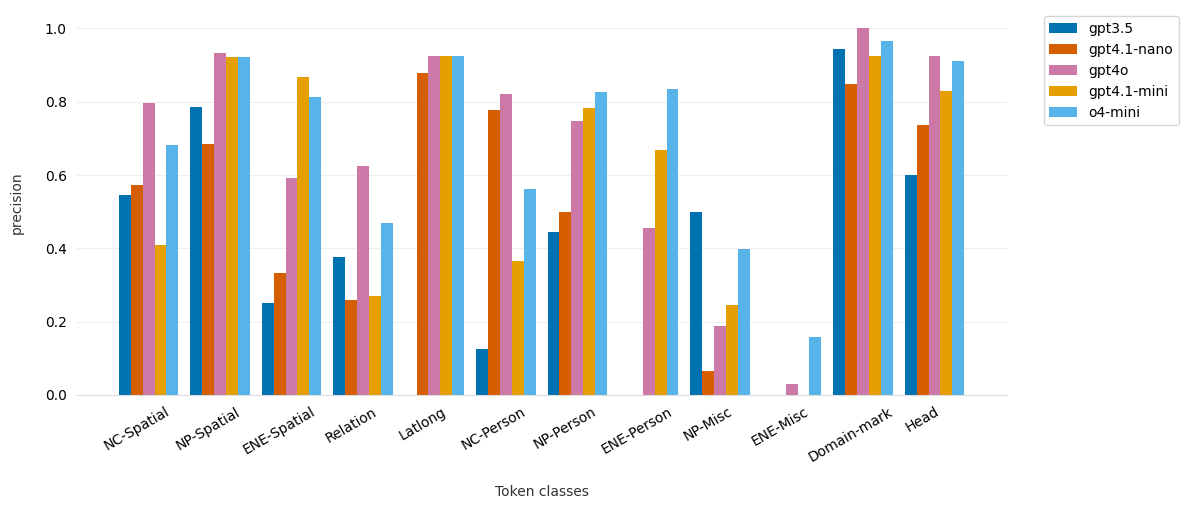

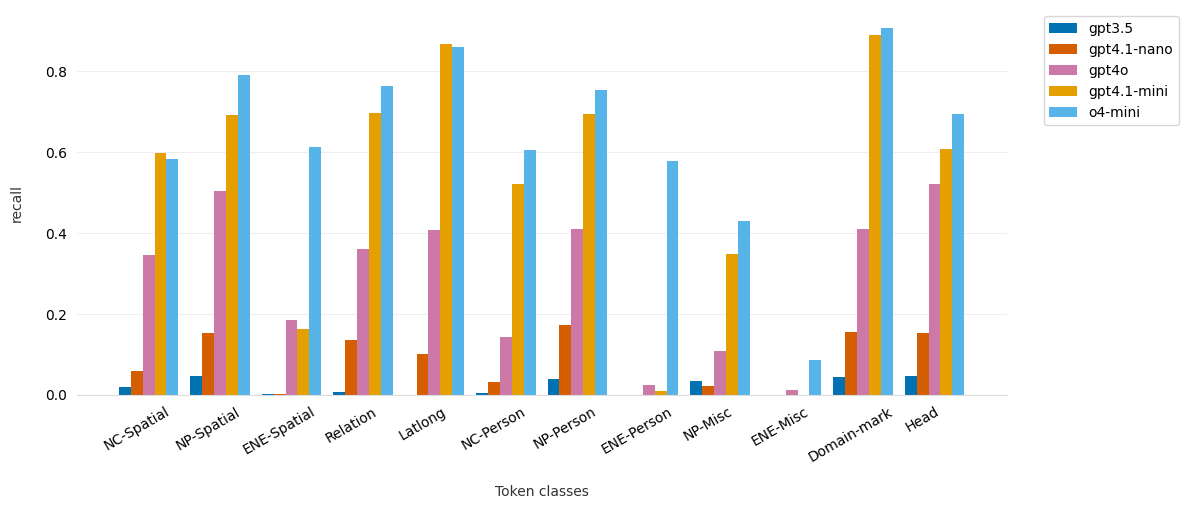

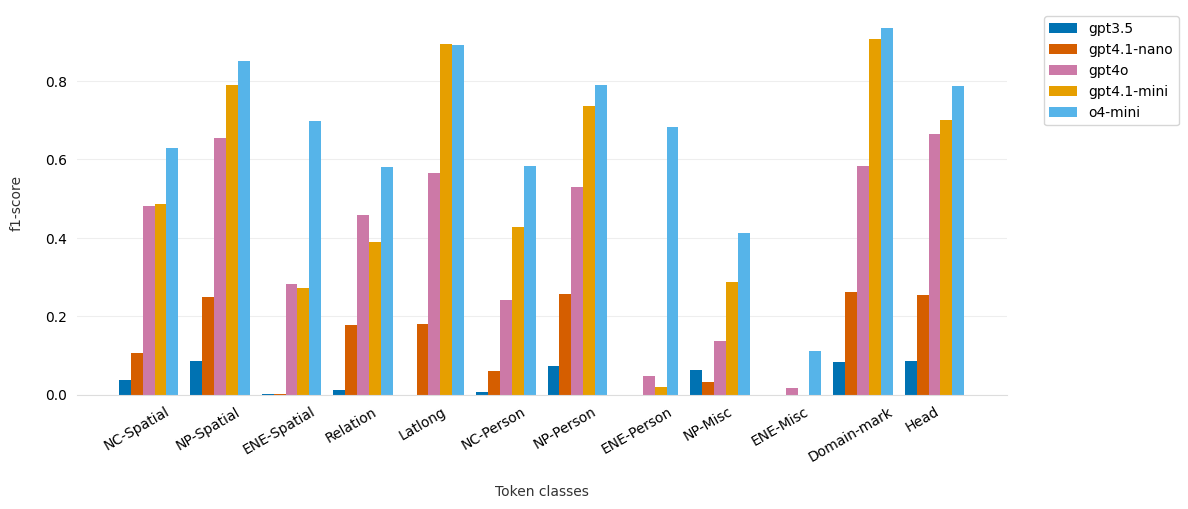

In [67]:
eval_scores = {}

for metric in metrics:
    for model in models:
        path = join('predictions','token_classification_' + model)

        predictions = load_predictions(path)
        classification_reports = evaluate(predictions, test_set, tagset)
        eval_scores[model] = get_avg_scores(classification_reports, metric)

    bar_plot(eval_scores, tagset, metric)
